In [334]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [306]:
def read_img(path):
    color_img = cv2.imread(path)
    color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)
    img = color_img.mean(axis=2) / 255
    return color_img, img

def get_gaussian_kernel(k=2, std=1):
    '''Returns a (2k+1)x(2k+1) gaussian kernel.'''
    x, y = np.mgrid[-k:k+1, -k:k+1]
    var = std ** 2
    kernel = 1/(2 * np.pi * var) * np.exp(-(x**2 + y**2) / (2 * var))
    return kernel

def gaussian_blur(img, k=2, std=1):
    kernel = get_gaussian_kernel(k=k, std=std)
    return cv2.filter2D(img, ddepth=-1, kernel=kernel)

def quantize_img(img, k=5):
    return (img * k).astype(int).astype(float) / k

In [3]:
def show_image(image):
    fig, ax = plt.subplots(1, 2, figsize=(20, 20))
    ax[0].imshow(image) 
    ax[1].imshow(image, cmap='gray')
    plt.show()

In [103]:
# Load the image
image_path = 'original/20230802_163315 copy.jpg'
blurred_image_path = 'blurred/20230802_163315 copy.jpeg'

# image_path = 'original/20230803_204918.jpg'
# blurred_image_path = 'blurred/20230803_204918.jpeg'

In [104]:
image_rgb, image = read_img(image_path)
blurred_image_rgb, blurred_image = read_img(blurred_image_path)

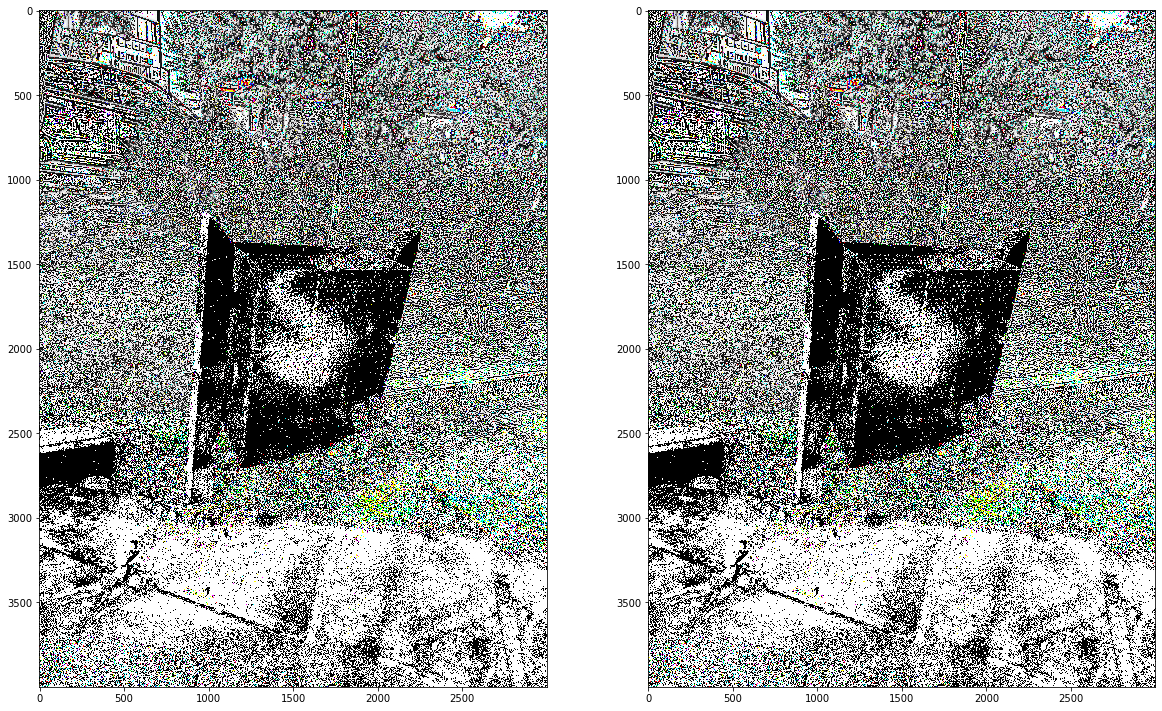

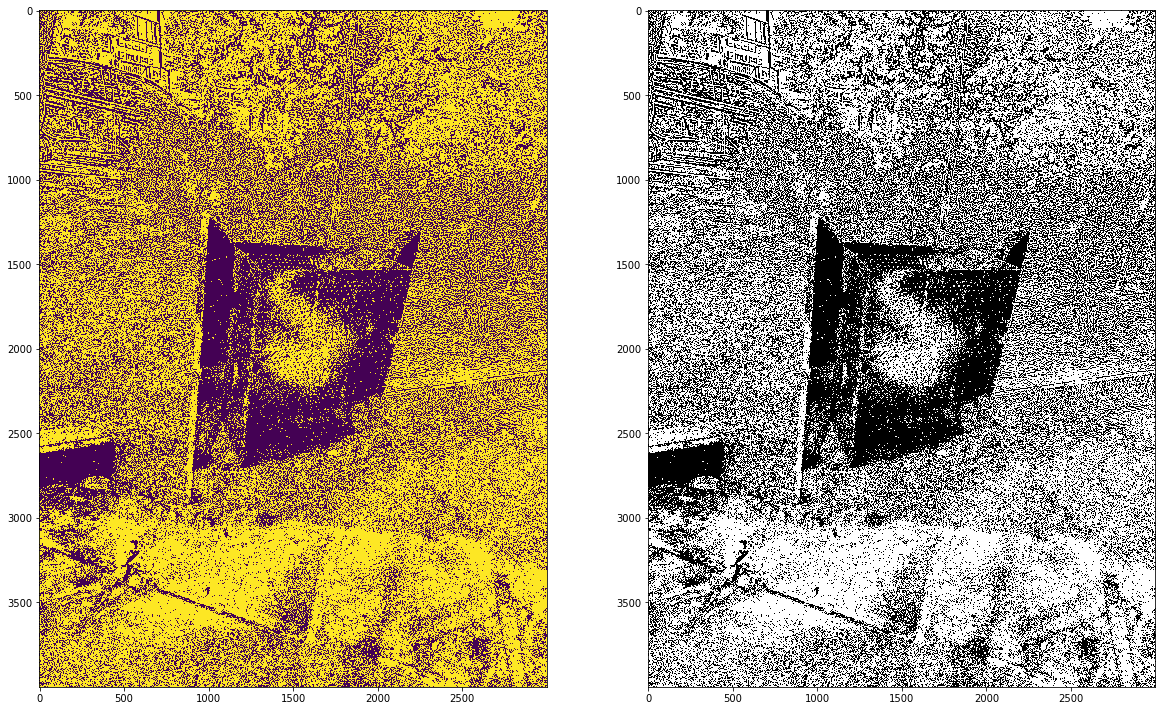

In [107]:
diff = np.abs(blurred_image_rgb - image_rgb)
heatmap = (diff.sum(axis=2) > 0.7 * diff.max()).astype(float)
show_image(diff)
show_image(heatmap)

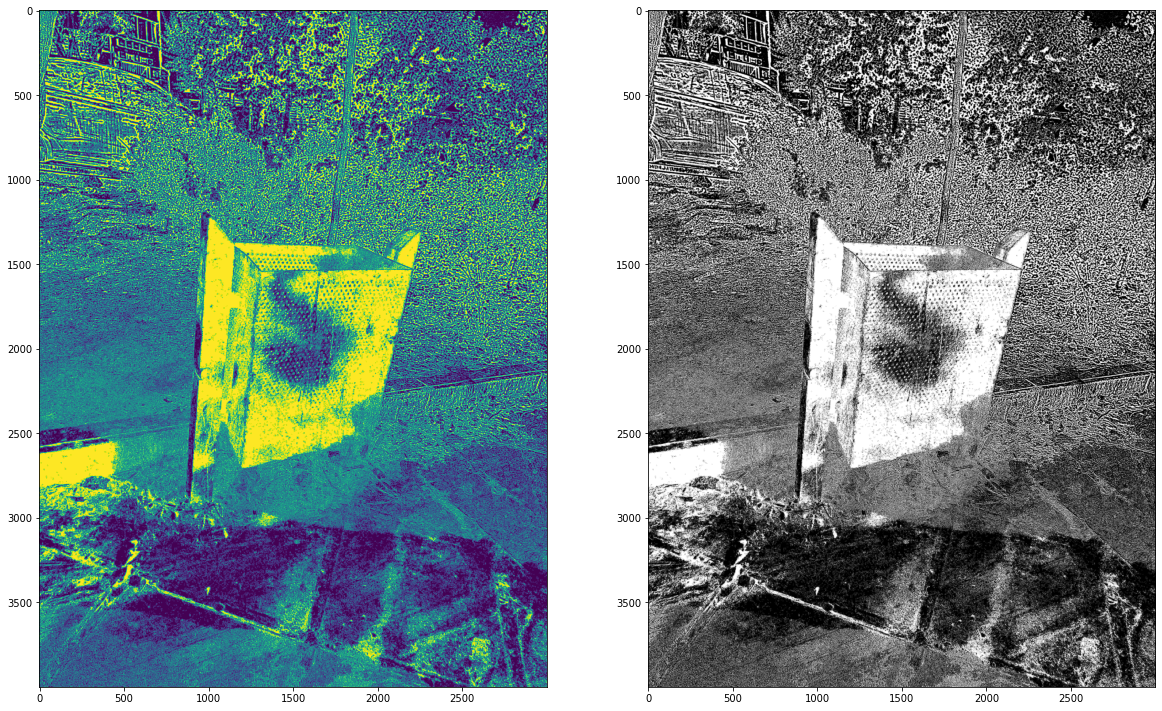

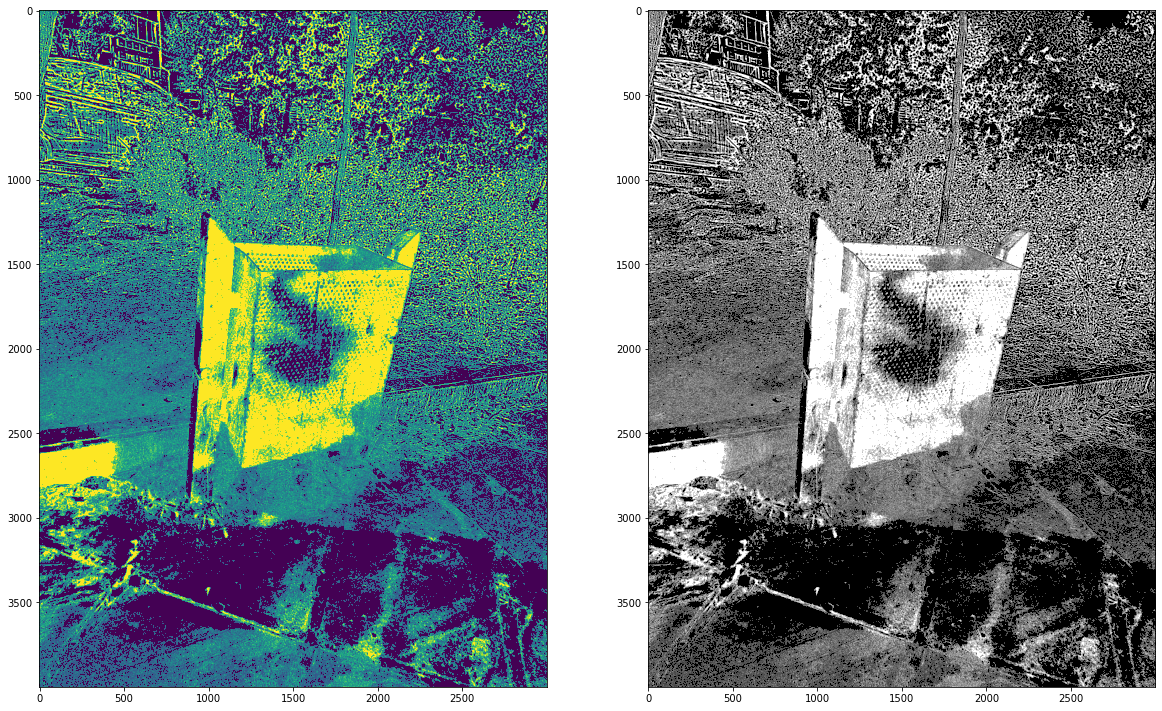

In [108]:
k = min(heatmap.shape) // 500
std = k ** 0.5
g_heatmap = 1 - gaussian_blur(heatmap, k=k, std=std)
show_image(g_heatmap)

t_g_heatmap = g_heatmap.copy()
d_threshold = 0.25
u_threshold = 0.90
t_g_heatmap[t_g_heatmap < threshold] = 0
t_g_heatmap[t_g_heatmap > u_threshold] = 1
show_image(t_g_heatmap)

143


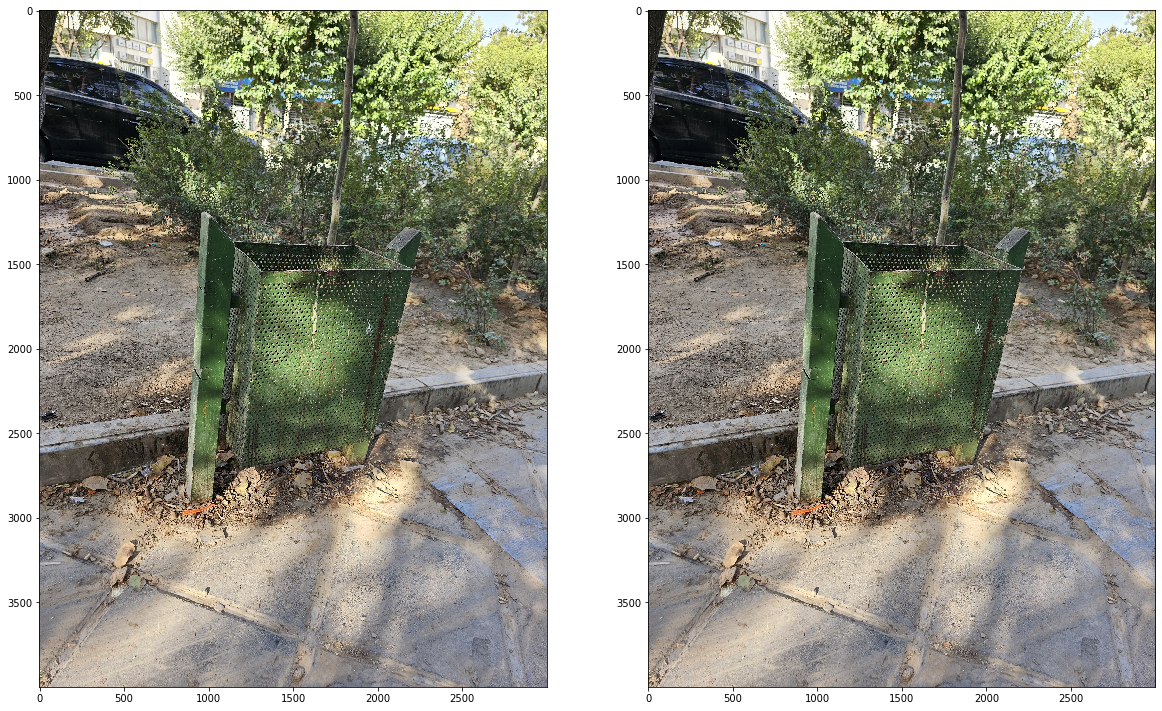

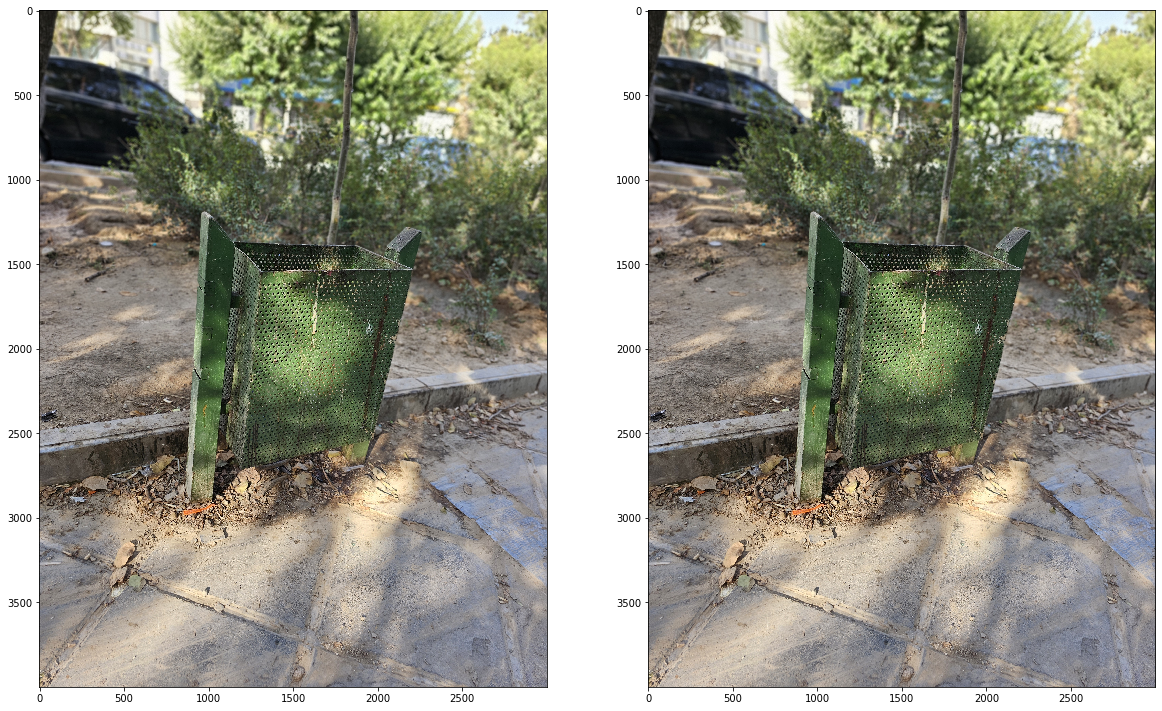

In [330]:
index = np.random.randint(1, 500)
color_img, img = read_img(f'./Dataset/RealWorld/Input_Images/{index}.jpg')
gt_color_img, gt_img = read_img(f'./Dataset/RealWorld/GT_Images/{index}.jpg')

# color_img, img = read_img(f'./original/20230803_204918.jpg')
# gt_color_img, gt_img = read_img(f'./blurred/20230803_204918.jpeg')

color_img, img = read_img(f'./original/20230802_163315 copy.jpg')
gt_color_img, gt_img = read_img(f'./blurred/20230802_163315 copy.jpeg')

print(index)
show_image(color_img)
show_image(gt_color_img)

In [294]:
CONFIGS = [
    {
        'k': 7,
        'std': 2.65,
        'd_threshold': 0.9,
        'u_threshold': 0.9,
        'diff_threshold': 0.7,
        'morphology': [
            {
                'type': cv2.MORPH_CLOSE,
                'kernel': np.ones((5, 5)),
                'iterations': 10,
            },
            {
                'type': cv2.MORPH_ERODE,
                'kernel': np.ones((5, 5)),
                'iterations': 5,
            },
            {
                'type': cv2.MORPH_DILATE,
                'kernel': np.ones((7, 7)),
                'iterations': 10,
            },
        ]
    }
]

In [332]:
def get_mask(
    original_img, blurred_img, 
    diff_threshold=0.7, 
    k=None,
    std=None,
    d_threshold=0.90,
    u_threshold=0.90,
):
    if k is None:
        k = 7
    if std is None:
        std = k * 0.5
    diff = np.abs(blurred_img - original_img)
    if len(diff.shape) > 2:
        diff = diff.sum(axis=2)
    diff = gaussian_blur(diff, k=k, std=std)
    diff = (diff > diff_threshold * diff.max()).astype(float)
    diff = gaussian_blur(diff, k=k, std=std)
    d_max = diff.max()
    if d_max > 0:
        diff /= d_max
    diff = 1 - diff
    diff[diff < d_threshold] = 0
    diff[diff >= u_threshold] = 1

#     for morph in CONFIGS[0]['morphology']:
#         diff = cv2.morphologyEx(diff, morph['type'], morph['kernel'], iterations=morph['iterations'])
#     diff = cv2.morphologyEx(diff, cv2.MORPH_CLOSE, np.ones((5, 5)), iterations=10)
    diff = cv2.morphologyEx(diff, cv2.MORPH_ERODE, np.ones((5, 5)), iterations=5)
    diff = cv2.morphologyEx(diff, cv2.MORPH_DILATE, np.ones((5, 5)), iterations=15)
    return diff

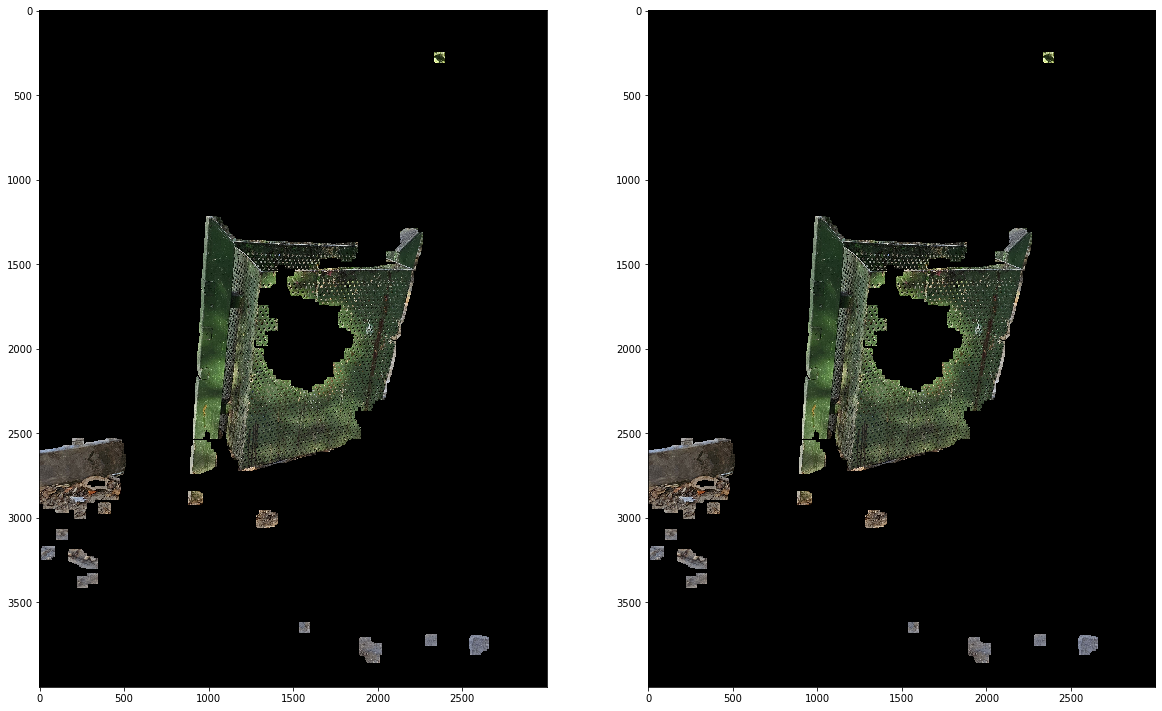

In [333]:
show_image(get_mask(color_img, gt_color_img, diff_threshold=0.4)[:, :, np.newaxis] * color_img / 255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


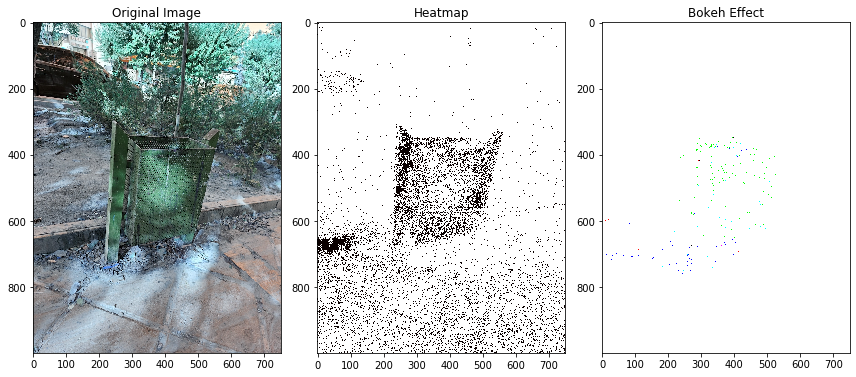

In [7]:
def apply_bokeh_effect(image, heatmap, strength=0.5):
    blurred = cv2.GaussianBlur(image, (0, 0), 2)
    bokeh = image * (1 - heatmap[:, :, np.newaxis] * strength) + blurred * (heatmap[:, :, np.newaxis] * strength)
    return bokeh

bokeh_image = apply_bokeh_effect(image_rgb, heatmap)

plt.figure(figsize=(12, 6))

plt.subplot(131)
plt.imshow(image_rgb)
plt.title('Original Image')

plt.subplot(132)
plt.imshow(heatmap, cmap='hot')
plt.title('Heatmap')

plt.subplot(133)
plt.imshow(bokeh_image)
plt.title('Bokeh Effect')

plt.tight_layout()
plt.show()

In [8]:

contours, _ = cv2.findContours((image * 255).astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


filled_image = np.zeros_like(image)

for contour in contours:
    cv2.drawContours(filled_image, [contour], 0, 1, thickness=cv2.FILLED)

print(contours)

(array([[[  0,   0]],

       [[  0, 177]],

       [[  1, 178]],

       [[  0, 179]],

       [[  0, 999]],

       [[749, 999]],

       [[749,   0]]], dtype=int32),)


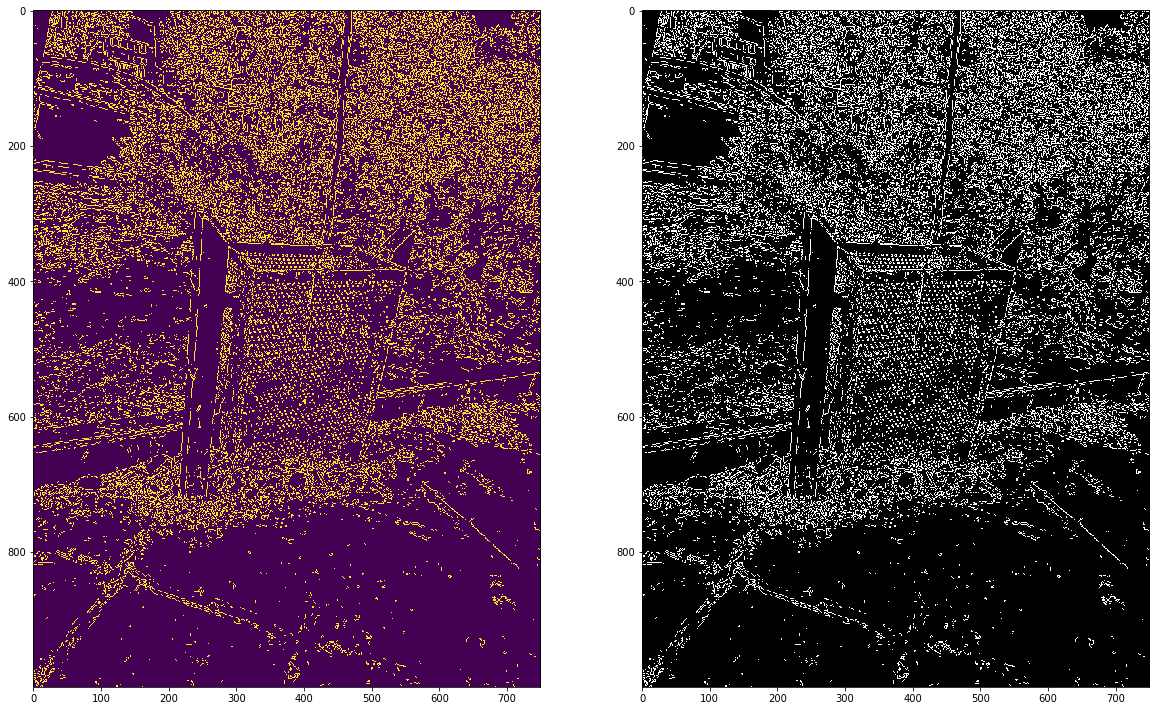

In [15]:

t_lower = 200  # Lower Threshold
t_upper = 255  # Upper threshold
  
edge = cv2.Canny(image_rgb, t_lower, t_upper)
  
show_image(edge)